# Phenospot data analysis

#### Imports

In [1]:
import numpy as np

import matplotlib.pyplot as plt

from matplotlib.animation import FFMpegWriter
from pathlib import Path

import Config as cfg
import Functions as fn

# from CreatePhasecontrastVideo import create_phase_contrast_video
from datetime import datetime
# from CreateResonantStack import create_res_map
from PIL import Image

#### Create Phase-contrast Video

In [2]:
# t_interval = create_phase_contrast_video()

PhC_path = Path(cfg.root_path, cfg.exp_path, 'Phasecontrast')

PhC_data_paths = [p for p in PhC_path.glob('*.tiff')]
PhC_data_paths.sort(key=lambda x: x.parts[-1])

mod_time = list()
for PhC_fp in PhC_data_paths:
    m_timestamp = PhC_fp.stat().st_mtime
    mod_time.append(datetime.fromtimestamp(m_timestamp))

t_interval = [((t - mod_time[0]).seconds/3600) +
                cfg.act_time for t in mod_time]

Frame 1 of 10 written
Frame 2 of 10 written
Frame 3 of 10 written
Frame 4 of 10 written
Frame 5 of 10 written
Frame 6 of 10 written
Frame 7 of 10 written
Frame 8 of 10 written
Frame 9 of 10 written
Frame 10 of 10 written


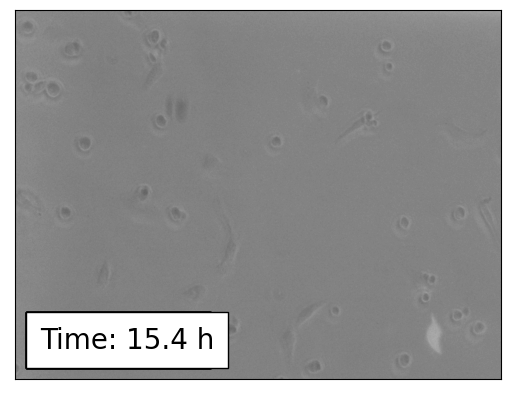

In [3]:
save_path = Path(cfg.root_path, cfg.exp_path, cfg.PhC_video)
fn.save_phasecontrast_video(t_interval, PhC_data_paths, save_path)

#### Create Resonant Map Stack

In [4]:
# map_store = create_res_map()

HyS_path = Path(cfg.root_path, cfg.exp_path, 'Hyperspectral')

HyS_data_paths = [p for p in HyS_path.iterdir() if p.is_dir()]
HyS_data_paths.sort(key=lambda x: int(x.parts[-1]))

temp_path = list(HyS_data_paths[0].glob('*.tiff'))[0]
temp_im = Image.open(temp_path)

# map_store = np.zeros((temp_im.size[1],
#                        temp_im.size[0],
#                        len(HyS_data_paths)))

map_store = np.zeros((len(HyS_data_paths),
                      temp_im.size[1],
                      temp_im.size[0]))

# Why do we remove a wave_step from wave_final
wav_ref = np.arange(cfg.wave_initial,
                    cfg.wave_final - cfg.wave_step,
                    cfg.wave_step)

im_list = list()
for H_idx, HyS_fp in enumerate(HyS_data_paths):

    imstack = fn.build_image_stack(HyS_fp)
    # Results in a 2.2Gb file, larger than images when stored separately
    # np.save(f'imstack_{H_idx}.npy', imstack)

    resonance_indexes = fn.get_resonance_idxs(imstack)
    map_store[H_idx, :, :] = wav_ref[resonance_indexes]

    # Multiply resonant data by 10 so not to lose resolution (i.e. take
    # one decimal place f64 and make compatible with int16) then scale for
    # uint16 (i.e. min value 0, max 65536)
    u16in = (((wav_ref[resonance_indexes] - cfg.wave_initial) * 10)
                * (65536 / ((cfg.wave_final - cfg.wave_initial) * 10)))
    u16in = u16in.astype(np.uint16)
    out_pil = u16in.astype(u16in.dtype.newbyteorder('<')).tobytes()
    img_out = Image.frombytes('I;16', (1920, 1460), out_pil)
    im_list.append(img_out)

    print(f'Resonant map {H_idx + 1} of {len(HyS_data_paths)} complete')

Imported image 0 of 20
Imported image 1 of 20
Imported image 2 of 20
Imported image 3 of 20
Imported image 4 of 20
Imported image 5 of 20
Imported image 6 of 20
Imported image 7 of 20
Imported image 8 of 20
Imported image 9 of 20
Imported image 10 of 20
Imported image 11 of 20
Imported image 12 of 20
Imported image 13 of 20
Imported image 14 of 20
Imported image 15 of 20
Imported image 16 of 20
Imported image 17 of 20
Imported image 18 of 20
Imported image 19 of 20
Resonant map 1 of 10 complete
Imported image 0 of 20
Imported image 1 of 20
Imported image 2 of 20
Imported image 3 of 20
Imported image 4 of 20
Imported image 5 of 20
Imported image 6 of 20
Imported image 7 of 20
Imported image 8 of 20
Imported image 9 of 20
Imported image 10 of 20
Imported image 11 of 20
Imported image 12 of 20
Imported image 13 of 20
Imported image 14 of 20
Imported image 15 of 20
Imported image 16 of 20
Imported image 17 of 20
Imported image 18 of 20
Imported image 19 of 20
Resonant map 2 of 10 complete


In [5]:
save_path = Path(cfg.root_path, cfg.exp_path, cfg.map_data)
print(f'Resonant map data -> {str(save_path)}')
np.save(save_path, map_store)

save_path = Path(cfg.root_path,
                 cfg.exp_path,
                 f'{cfg.map_data[:-4]}.tiff')
print(f'Resonant map data as TIFF stack -> {str(save_path)}')
im_list[0].save(save_path,
                format='TIFF',
                save_all=True,
                append_images=im_list[1:])

Resonant map data -> /Users/chris/Documents/SoftwareDev/Python/Phenospot/Data/Location_1/mapstore.npy
Resonant map data as TIFF stack -> /Users/chris/Documents/SoftwareDev/Python/Phenospot/Data/Location_1/mapstore.tiff


### Data Analysis

#### Single ROI
- Get ROI from user
- Slice resonant stack using ROI
- Take average over ROI, of each resonant image within stack
- Display ROI of last image in resonant stack
- Display resonant shifts over time
- Display spectrum for each resonant image

In [6]:
''' Why do we remove a wave_step from wave_final'''
wav_ref = np.arange(cfg.wave_initial,
                    cfg.wave_final - cfg.wave_step,
                    cfg.wave_step)

''' Get ROI from user'''
# rect_coords = fn.get_area(map_store[:, :, -1])
rect_coords = [(50, 50),(200, 200)]

''' Slice resonant map to ROI'''
map_regions = map_store[:,
                        rect_coords[0][1]:rect_coords[1][1],
                        rect_coords[0][0]:rect_coords[1][0]]

''' Take average resonant wavelength over ROI for each time step'''
av_spec = np.mean(map_regions, axis=(1, 2))

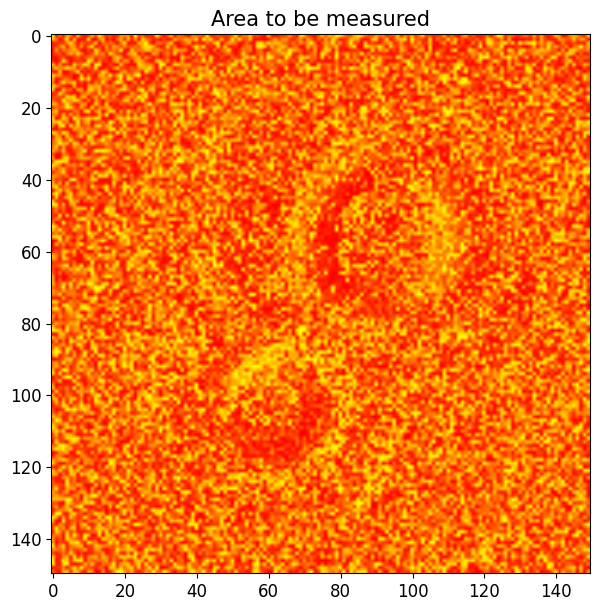

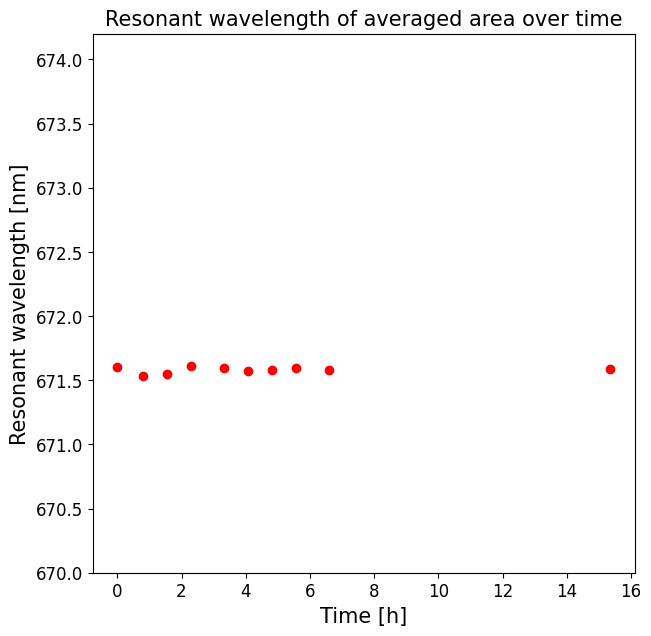

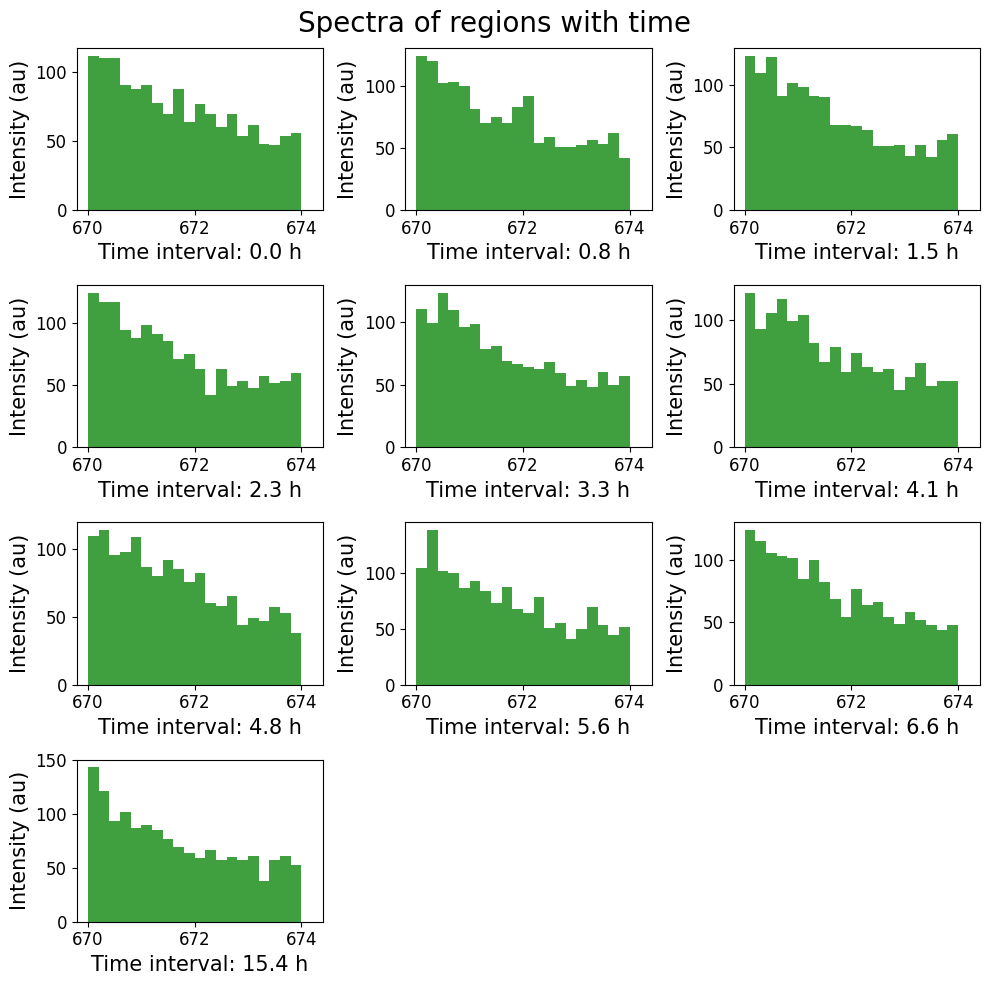

In [7]:
''' Display ROI of resonant map for last time step'''
fig = plt.figure(figsize=(7, 7))
plt.rcParams.update(fn.FONT_PARAMS)
plt.title('Area to be measured')
plt.imshow(map_regions[-1, :, :],
           interpolation='bilinear',
           cmap='autumn')
plt.show()
# plt.pause(1)
# plt.close()

'''Disply resonant shift with time'''
fig = plt.figure(figsize=(7, 7))
plt.rcParams.update(fn.FONT_PARAMS)
plt.title('Resonant wavelength of averaged area over time')
plt.plot(t_interval, av_spec, 'or')
plt.ylim((cfg.wave_initial, cfg.wave_final))
plt.xlabel('Time [h]')
plt.ylabel('Resonant wavelength [nm]')
plt.show()
# plt.pause(1)
# plt.close()

'''Display spectra from regions'''
bins = np.arange(cfg.wave_initial,
                 cfg.wave_final,
                 cfg.wave_step)

fig = plt.figure(figsize=(10, 10))
plt.rcParams.update(fn.FONT_PARAMS)
plt.suptitle('Spectra of regions with time')
sub_x = int(np.ceil(np.sqrt(len(t_interval))))
sub_y = int(np.ceil(len(t_interval) / sub_x))

for idx, t in enumerate(t_interval):
    sub = fig.add_subplot(sub_x, sub_y, idx + 1)
    sub.set_xlabel(f'Time interval: {t:.1f} h')
    sub.set_ylabel('Intensity (au)')
    sub.hist(np.ravel(map_regions[:, :, idx]),
             bins=bins,
             density=False,
             facecolor='g',
             alpha=0.75)
fig.tight_layout()
plt.show()
# plt.pause(1)
# plt.close()

#### Multiple ROI
- Get ROIs from user
- Save ROI coordinates to file
- Slice resonant stack using ROIs, store in list
- Take average over each ROI, for each resonant image within stack
- Save resonant shifts to file
- Display resonant shifts for each ROI
- Create video of ROIs
- Plot histogram of resonant shifts
- Plot box plot of resonant shifts

In [8]:
'''Get ROIs from user'''
# num_of_ROIs = cfg.cell_num
# roi_locs = fn.get_ROI_areas(map_store[:, :, -1], num_of_pts=num_of_ROIs)
num_of_ROIs = 2
roi_locs = [[(50, 50), (200, 200)],
             [(100, 100), (250, 250)]]

'''Slice hyperspectral maps into ROI regions'''
roi_regions = list()
for r in roi_locs:
    temp = map_store[:, r[0][1]:r[1][1], r[0][0]:r[1][0]]
    roi_regions.append(temp)

'''Calculate mean value of each region (i.e average resonant wavelength)
   at each time interval.  Shift all datapoints so that first datapoint starts
   at zero'''
av_shift = list()
for roi in roi_regions:
    av = np.mean(roi, axis=(1, 2))
    av_shift.append(av - av[0])

In [ ]:
save_path = Path(cfg.root_path, cfg.exp_path)

print(f'ROI locations -> {str(Path(save_path, cfg.roirect_data))}')
np.save(Path(save_path, cfg.roirect_data), np.array(roi_locs))

print(f'Resonant shifts -> {str(Path(save_path, cfg.av_shift_data))}')
np.save(Path(save_path, cfg.av_shift_data), np.array(av_shift))

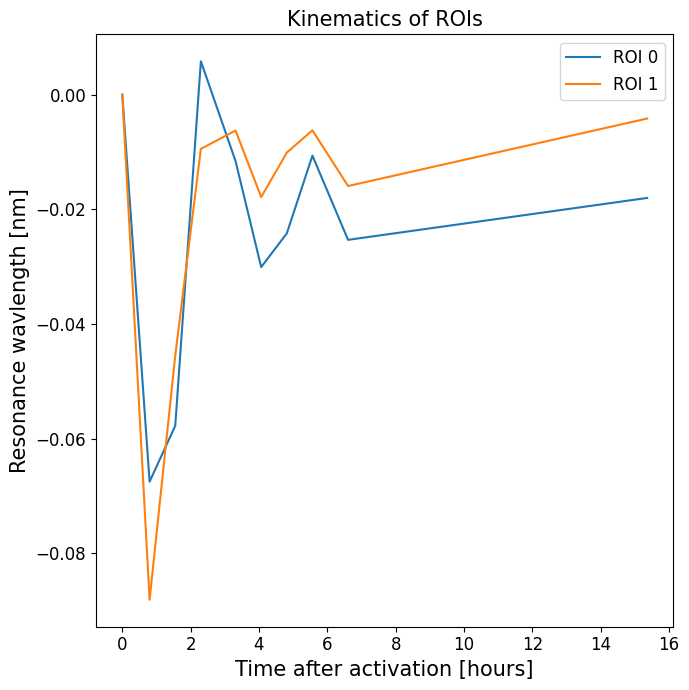

In [9]:
'''Display kinematics from different ROIs'''
fig = plt.figure(figsize=(7, 7))
plt.rcParams.update(fn.FONT_PARAMS)
plt.title('Kinematics of ROIs')
for idx, data in enumerate(av_shift):
    plt.plot(t_interval, data, label=f'ROI {idx}')
plt.xlabel('Time after activation [hours]')
plt.ylabel('Resonance wavlength [nm]')
plt.legend()
fig.tight_layout()
plt.show()
# plt.pause(1)
# plt.close()


In [ ]:
save_path = Path(cfg.root_path, cfg.exp_path)
plt.savefig(Path(save_path, cfg.res_over_t_chart), format='png')
print(f'Resonant shifts chart -> {str(Path(save_path, cfg.res_over_t_chart))}')

Frame 1 of 10 written
Frame 2 of 10 written
Frame 3 of 10 written
Frame 4 of 10 written
Frame 5 of 10 written
Frame 6 of 10 written
Frame 7 of 10 written
Frame 8 of 10 written
Frame 9 of 10 written
Frame 10 of 10 written
Hyperspectral video -> /Users/chris/Documents/SoftwareDev/Python/Phenospot/Data/Location_1/loc01_ROI_HyS.mp4


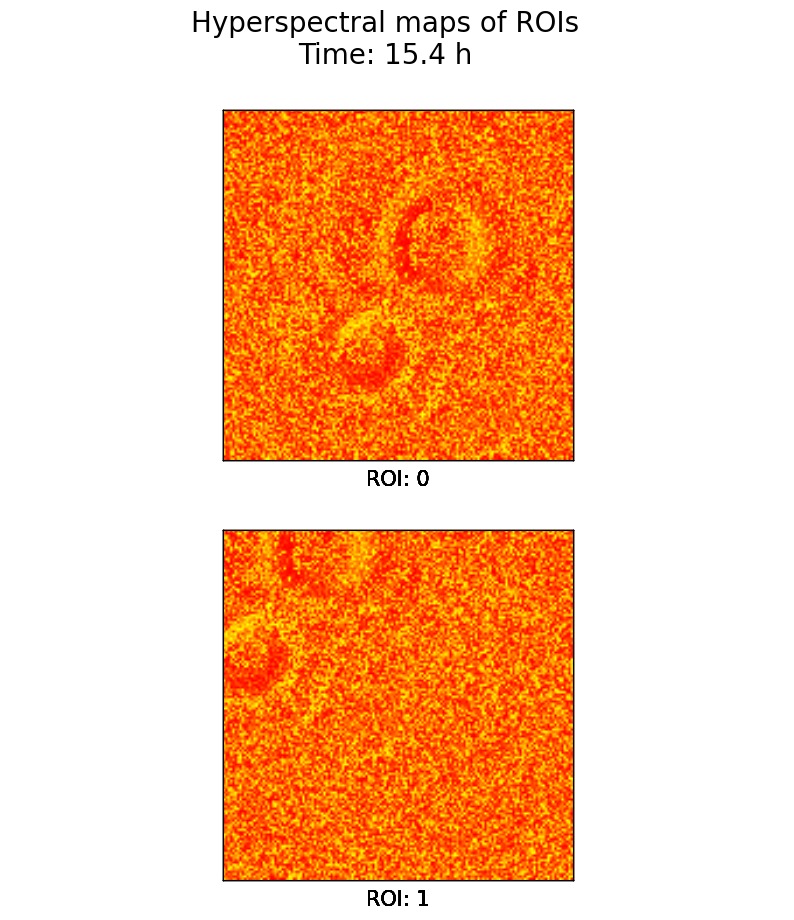

In [10]:
save_path = Path(cfg.root_path, cfg.exp_path)

'''Produce video of hyperspectral images of ROIs'''
writer = FFMpegWriter(fps=2)
fig = plt.figure(figsize=(10, 10))
plt.rcParams.update(fn.FONT_PARAMS)
plt.suptitle('Hyperspectral maps of ROIs')
plt.gca().axes.axis('off')
with writer.saving(fig, Path(save_path, cfg.HyS_video), dpi=100):
    for Hyp_idx, t in enumerate(t_interval):
        plt.suptitle(f'Hyperspectral maps of ROIs\nTime: {t:0.1f} h')
        for idx, r in enumerate(roi_locs):
            temp = map_store[Hyp_idx, r[0][1]:r[1][1], r[0][0]:r[1][0]]

            sub_x = int(np.ceil(np.sqrt(num_of_ROIs)))
            sub_y = int(np.ceil(num_of_ROIs / sub_x))
            sub = fig.add_subplot(sub_x, sub_y, idx + 1)
            sub.axes.get_xaxis().set_ticks([])
            sub.axes.get_yaxis().set_ticks([])
            sub.set_xlabel(f'ROI: {idx}')
            sub.imshow(temp,
                       interpolation='bilinear',
                       cmap='autumn')
        writer.grab_frame()
        print(f'Frame {Hyp_idx + 1} of {len(t_interval)} written')
print(f'Hyperspectral video -> {str(Path(save_path, cfg.HyS_video))}')
# plt.close()
plt.show()


Histogram data -> /Users/chris/Documents/SoftwareDev/Python/Phenospot/Data/Location_1/loc_01_hist_ROI_av.npy


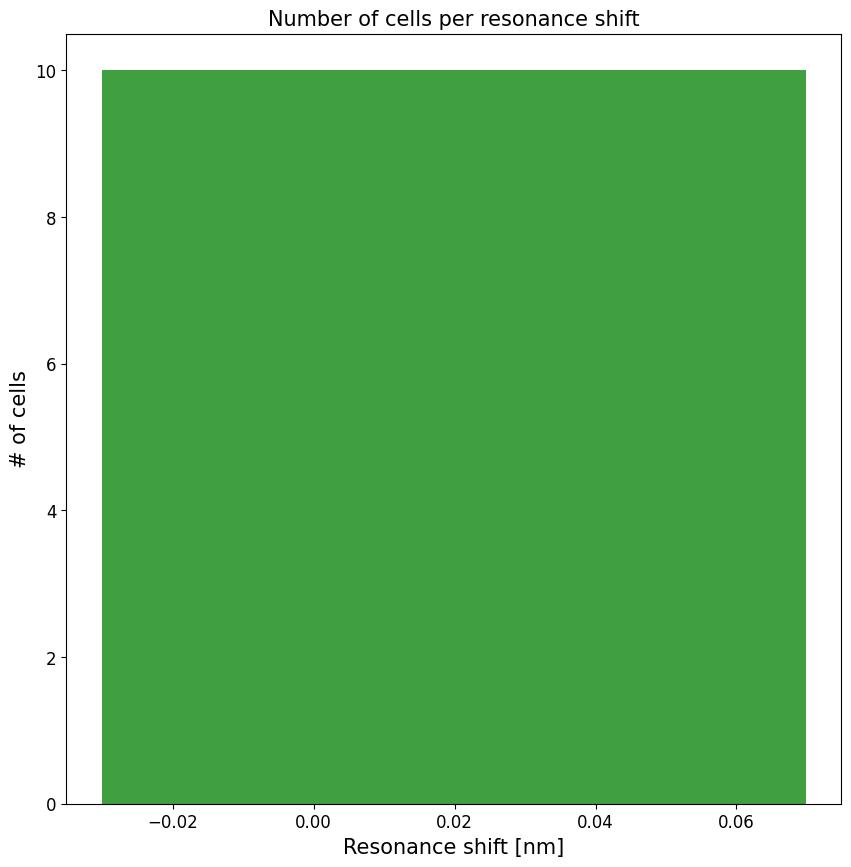

In [11]:
'''Plot histogram of cell count versus resonant wavlength.  Only take value
   from 5th time interval ???'''
# How many points do you want to consider for the average resonance shift
# over time?
fin = 5
hist_data = [a[fin] for a in av_shift]

print(f'Histogram data -> {str(Path(save_path, cfg.histogram_data))}')
np.save(Path(save_path, cfg.histogram_data), np.array(hist_data))

binwidth = 0.1
bins = np.arange(np.amin(hist_data), np.amax(hist_data) + binwidth, binwidth)

fig = plt.figure(figsize=(10, 10))
plt.rcParams.update(fn.FONT_PARAMS)
plt.title('Number of cells per resonance shift')
plt.hist(hist_data, bins=bins, density=True, facecolor='g', alpha=0.75)
plt.xlabel('Resonance shift [nm]')
plt.ylabel('# of cells')
plt.show()
# plt.pause(1)
# plt.close()


In [ ]:
save_path = Path(cfg.root_path, cfg.exp_path)
plt.savefig(Path(save_path, cfg.histogram_chart), format='png')
print(f'Histogram chart -> {str(Path(save_path, cfg.histogram_chart))}')

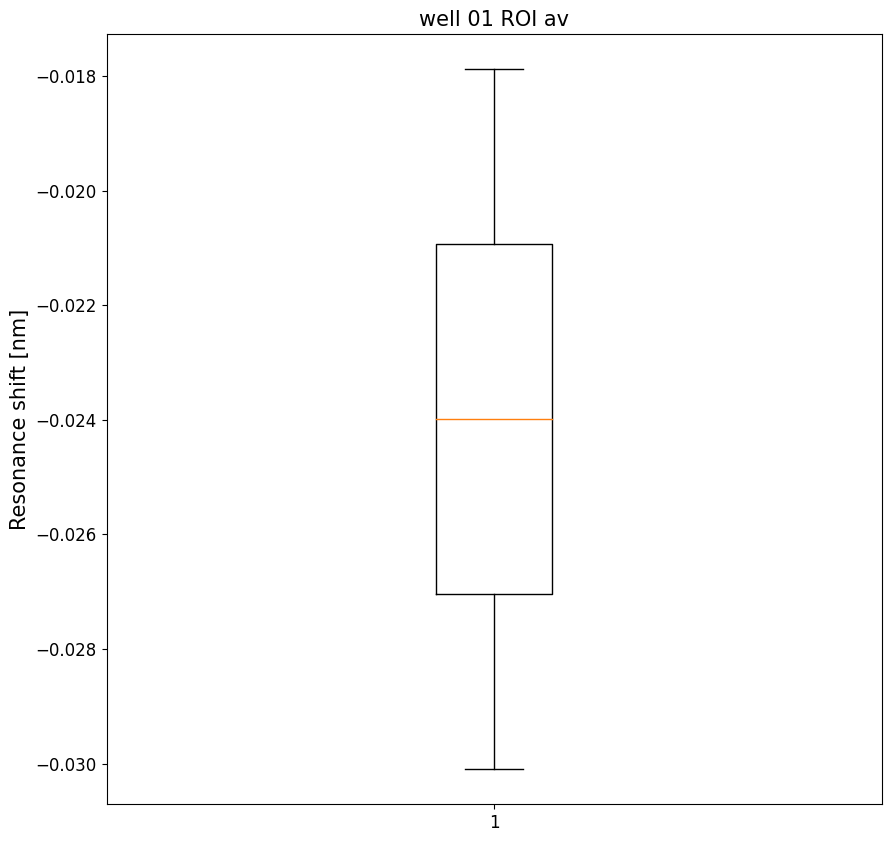

In [12]:
'''Plot boxplot of histogram data for improved data visualisation'''
legend_name = 'well 01 ROI av'  # Needs to be constructed not hard-written
fig = plt.figure(figsize=(10, 10))
plt.rcParams.update(fn.FONT_PARAMS)
plt.title(legend_name)
plt.boxplot(hist_data)
plt.ylabel('Resonance shift [nm]')
plt.show()

In [ ]:
save_path = Path(cfg.root_path, cfg.exp_path)
plt.savefig(Path(save_path, cfg.boxplot_chart), format='png')
print(f'Boxplot chart -> {str(Path(save_path, cfg.boxplot_chart))}')